**Engy-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2024; Prof. V. F. de Almeida

# Constant Thermal Conductivity, Constant Source, and Dirichlet BC

**Student(s):**  Kyle Mills and Billy Manco and Donaita Anglade <br>
**Course:** Engy-4390: Nuclear Systems Design and Analysis  <br>
**Mentor and Collaborator:** Subash Sharma

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**21 Oct 2024**

---
## Table of Contents<a id="toc"></a>
* [Problem conditions](#whatisit)
* [Setup](#setup)
* [Test One](#test)
---

## [Problem Data](#toc)<a id="setup"></a>

Heating power density, $f$, is not dependent on position, thermal conductivity, $k$, is a constant:

+ $k = 31 \left [ \frac{W}{mK} \right ]$
+ $f = 206151 \; \left [ \frac{W}{m^{3}} \right ]$

and the temperature at the ends of the domain are specified as a Dirichlet BC:

+ $T(a) = 20$ [°C], and $T(b)= 40$ [°C].

## [Setup FEM](#toc)<a id="setup"></a>

In [1]:
'''Domain'''
'''Rayleigh Ritz Method with Lagrange FE Basis Functions'''
x_min = 0     # m
x_max = 0.05  # m

degree = 2  # Degree of the lagrange polinomials used
n_elem = 10 # Number of elements used

In [2]:
'''Domain partition'''
from pyfires import get_domain_partition
'''Parent mapping'''
from pyfires import get_parent_mapping
'''The basis functions'''
from pyfires import get_parent_basis_functions
'''Again the function for the obtaining of the basis functions'''
from pyfires import global_basis_function
'''All global basis functions'''
from pyfires import get_global_basis_functions
'''Inner product'''
from pyfires import inner_product

## [Implementing Data](#toc)<a id="test"></a>

Test one constraints the system to a constant conductivity and constant source term with a Dirichlet boundary condition. The goal of simulating the domain under these conditions is to produce a graphical solution on how heat is transfered. 

In [3]:
'''Thermal conductivity'''
from pyfires import linear_func
from pyfires import plot_func

k_func = linear_func(x_min, x_max, (31.0, 31.0)) # W/mK

'''Heating Power Density'''
f_func = linear_func(x_min, x_max, (206151.0, 206151.0)) # W/m^3

view_plots = False

In [4]:
if view_plots:
    n_plot_pts = 200
    title = 'Thermal Conductivity'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'K [W/mk]'
    plot_func(k_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

    title = 'Heating Power Density'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'f [W/m^3]'
    plot_func(f_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

In [5]:
'''FEM Solution'''
domain_partition = get_domain_partition(degree, n_elem, x_min, x_max)
parent_mapping = get_parent_mapping()
parent_basis_functions = get_parent_basis_functions()

phi_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[0]
phi_prime_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[1]

In [6]:
'''Building the lift function'''
u_a = 20 #temperature at point a in degrees C
u_b = 40 #temperature at point b in degrees C

lift_func = linear_func(x_min, x_max, (u_a, u_b)) # C
lift_prime = (u_b-u_a)/(x_max-x_min)
lift_func_prime = linear_func(x_min, x_max, (lift_prime, lift_prime)) # C

view_plots = False

In [7]:
if view_plots:
    n_plot_pts = 200
    title = 'Lift Function'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'T [C]'
    plot_func(lift_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

    title = 'Lift Function Prime'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'dT/dx [C/m]'
    plot_func(lift_func_prime, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

In [8]:
'''Build FEM A matrix'''
from pyfires import build_a_mtrx

a_mtrx = build_a_mtrx(phi_list, phi_prime_list, k_func, domain_partition, x_min, x_max, n_elem)

In [9]:
'''Build load vector'''
from pyfires import build_b_vec

b_vec = build_b_vec(phi_list, phi_prime_list, k_func, f_func, lift_func_prime, domain_partition, x_min, x_max, n_elem)

In [10]:
'''Solution'''
'''Compute optimal coefficient vector'''
import numpy as np

c_star_vec = np.linalg.solve(a_mtrx, b_vec)

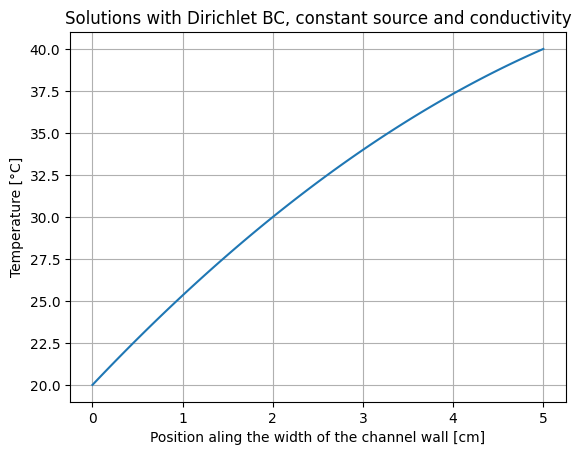

In [11]:
from pyfires import u_star

plot_func(lambda x: u_star(x, phi_list, lift_func, c_star_vec), x_min, x_max, 100,
          x_scale=100,
          title='Solutions with Dirichlet BC, constant source and conductivity', 
          xlabel='Position aling the width of the channel wall [cm]',
          ylabel='Temperature [°C]')

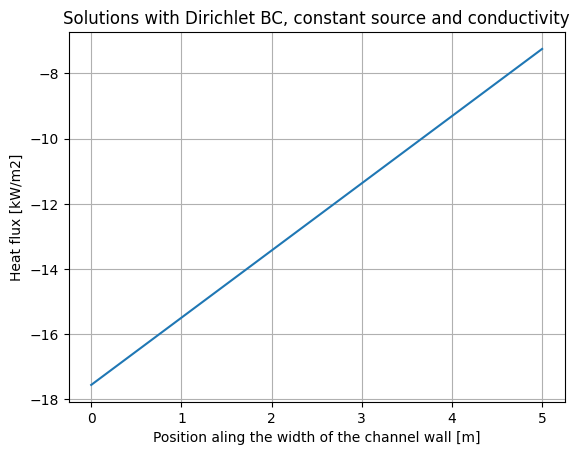

In [12]:
from pyfires import u_star_prime
h_e = (x_max-x_min)/n_elem
q_x = lambda x: - k_func(x) * u_star_prime(x, phi_prime_list, lift_func_prime, c_star_vec, h_e)
plot_func(q_x, x_min, x_max, 100, 
          x_scale=100, y_scale=1/1000,
          title='Solutions with Dirichlet BC, constant source and conductivity', 
          xlabel='Position aling the width of the channel wall [m]',
          ylabel='Heat flux [kW/m2]')

In [13]:
'''Normal heat flux at boundaries'''
n_x_a = -1.0
n_x_b =  1.0
print('q_n(a) = ', q_x(x_min) * n_x_a)
print('q_n(b) = ', q_x(x_max) * n_x_b)

q_n(a) =  [17553.775]
q_n(b) =  [-7246.225]
